# Analysis of MSC aging gene expression

See this website to browse and visualize gene expression:
https://tabula-muris-senis.ds.czbiohub.org

This notebook produces a list of genes that are differentially expressed in MSCs from multiple different tissues in the aging process. Specifically, it produces a list of "conserved" genes - genes that are upregulated in aging in at least 4 or 5 out of 6 tissues in which mesenchymal stem cells were found. "Upregulated" genes are enriched in aged animals (24-30 month) and "downregulated" genes are enriched in young animals (1-3 month). See the [Tabula Muris Senis publication](https://www.biorxiv.org/content/10.1101/661728v3) for more details on the data. 

For "strict" up/down regulation, a gene is considered up/down regulated if it is in the top 1000 up/down regulated genes in a tissue. For "loose" up/down regulation, a gene is considered up/down regulated if it is in the top 2500 up/down regulated genes in a tissue. All of these genes are technically significant by p-values. The purpose of using a cutoff of the top 1000 or 2500 based on foldchange is to select the genes with

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pickle
import re
from scipy import stats


data_path = '../data/tms_gene_data/'

In [7]:
with open(data_path + 'DE_result/DE_tissue_cell_droplet.pickle', 'rb') as handle:
    de_tissue_cell_droplet = pickle.load(handle)

with open(data_path + 'DE_result/DE_tissue_cell_FACS.pickle', 'rb') as handle:
    de_tissue_cell_facs = pickle.load(handle)

In [28]:
print("There are %d tissue-cell combos for droplet" % len(de_tissue_cell_droplet.keys()))

There are 62 tissue-cell combos for droplet


In [29]:
print("There are %d tissue-cell combos for facs" % len(de_tissue_cell_facs.keys()))

There are 131 tissue-cell combos for facs


Find the tisse-cell type differential expression results corresponding to MSCs:

In [46]:
de_msc_facs = {x: de_tissue_cell_facs[x] for x in de_tissue_cell_facs.keys() if re.search("mes.*stem", x)}
print('FACS: %s' % list(de_msc_facs.keys()))
de_msc_droplet = {x: de_tissue_cell_droplet[x] for x in de_tissue_cell_droplet.keys() if re.search("mes.*stem", x)}
print('droplet: %s' % list(de_msc_droplet.keys()))

FACS: ['Diaphragm.mesenchymal stem cell', 'BAT.mesenchymal stem cell of adipose', 'GAT.mesenchymal stem cell of adipose', 'SCAT.mesenchymal stem cell of adipose', 'MAT.mesenchymal stem cell of adipose', 'Limb_Muscle.mesenchymal stem cell']
droplet: ['Limb_Muscle.mesenchymal stem cell']


In [40]:
de_msc_facs['Diaphragm.mesenchymal stem cell'].sort_values('fc')

,gene,raw-p,coef,bh-p,fc
Lum,Lum,1.614028e-45,-0.086366,6.030061e-42,-2.033003
Gsn,Gsn,1.708042e-53,-0.097129,1.483605e-49,-1.898059
Dpysl2,Dpysl2,1.053850e-40,-0.064285,2.034164e-37,-1.699740
Sept2,Sept2,1.354558e-53,-0.060338,1.483605e-49,-1.695977
Ccdc80,Ccdc80,2.386673e-41,-0.093589,5.182660e-38,-1.650970
...,...,...,...,...,...
Rarres2,Rarres2,9.699563e-26,0.052477,2.674616e-23,0.893248
Rpl13a,Rpl13a,1.426203e-27,0.045198,4.858039e-25,0.900558
Ifitm3,Ifitm3,1.369645e-26,0.057763,4.032793e-24,0.907947
Mt2,Mt2,1.186346e-11,0.038798,3.553311e-10,0.965182


## Consistency of FACS vs droplet

First compare FACS vs droplet for muscle MSCs to show that the technologies are giving consistent answers

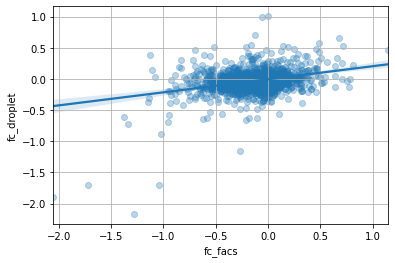

Cor: 0.327698, pval: 0.000000


In [80]:
common_tissue = 'Limb_Muscle.mesenchymal stem cell'

merged_de_results = de_msc_facs[common_tissue].rename(lambda x: x + '_facs', axis='columns'). \
merge(de_msc_droplet[common_tissue].rename(lambda x: x + '_droplet', axis='columns'), \
      left_index=True, right_index=True)

sns.regplot(x='fc_facs', y='fc_droplet', data=merged_de_results, scatter_kws={'alpha': 0.3})
plt.grid()
plt.show()
cor, pval = stats.spearmanr(merged_de_results['fc_facs'], merged_de_results['fc_droplet'])
print('Cor: %f, pval: %f' % (cor, pval))


Good, there is reasonable correlation between fold-changes and you can see that the FACS generates larger magnitude fold-changes, on average. 

In [69]:
merged_de_results.head()

,gene_facs,raw-p_facs,coef_facs,bh-p_facs,fc_facs,gene_droplet,raw-p_droplet,coef_droplet,bh-p_droplet,fc_droplet
0610005C13Rik,0610005C13Rik,2.849714e-02,NaN,5.089938e-02,0.000569,NaN,NaN,NaN,NaN,0.000000
0610007C21Rik,0610007C21Rik,5.836328e-17,0.010402,1.028038e-15,0.018930,0610007C21Rik,9.594277e-43,-0.005969,8.600809e-42,-0.134581
0610007L01Rik,0610007L01Rik,1.628186e-13,-0.002981,1.643550e-12,-0.088343,0610007L01Rik,1.618820e-57,-0.002756,4.067055e-56,-0.052177
0610007N19Rik,0610007N19Rik,1.516887e-18,0.000370,3.425001e-17,-0.046542,0610007N19Rik,1.927233e-197,-0.018410,7.927204e-195,-0.347530
0610007P08Rik,0610007P08Rik,1.676431e-06,-0.001291,6.306025e-06,-0.034364,0610007P08Rik,3.386750e-11,0.000336,7.354383e-11,0.004726


In [72]:
merged_de_results['is_significant_droplet'] = merged_de_results['bh-p_droplet'] < 0.01
merged_de_results['is_significant_facs'] = merged_de_results['bh-p_facs'] < 0.01
merged_de_results[['is_significant_droplet', 'is_significant_facs']].agg(func=sum)

is_significant_droplet    11950
is_significant_facs        8273
dtype: int64

Problem is, nearly half of genes are significantly changed. It's reasonable to assume only the highest-scoring are of biological importance (and it's probably also the case that the statistical test is overfitting to animal-animal variation). 

[None]

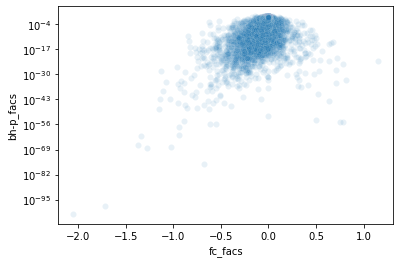

In [76]:
grid=sns.scatterplot(x='fc_facs', y='bh-p_facs', data=merged_de_results, alpha=0.1)
grid.set(yscale='log')

## Broadly-conserved MSC aging signatures

Question: what genes are broadly upregulated in MSC aging regardless of tissue? 

These genes are good candidates for a CRISPR screen since they are more likely to be core to the MSC aging process and more likely to validate in an in vitro system.

How can we define broadly upregulated MSC aging genes? They should be differentially expressed in *most* tissues, but requiring they be differentially expressed in *every* tissue is probably too strict and particularly will penalize experiments that test many tissues (the false negative rate linearly increases with the number of tissues for the 100% requirement). 

Therefore, compute and store the intersection of top $n$ differential genes for the different tissues that MSCs are present in. Due to the very large number ($\gt 8000$) number of significantly differential genes observed in each cell type and tissue, no p-value filtering is performed, and $n$ should be $\leq 4000$. I am assuming that the large number of cells is inflating the p-values, and that therefore selecting the top $n$ genes by foldchange is likely a better way of selecting genes.

In [173]:
class DegIntersection:
    """A class for computing and storing conserved DEGs from differential
    expression analysis of multiple celltypes. 
    
    Warning: it is assumed that the top n genes are significant, as no p-value 
    significance filtereing is performed.
    
    Attributes
    ----------
    celltype_deg_dict : dict
        a dictionary of str: pandas.DataFame key-value pairs, where the DataFrame
        has gene names as the Index, and a column 'fc' that stores the fold-changes
        
    celltypes : list
        a list of celltypes corresponding to the keys of deg_dict
        
    n : int
        the number of DEGs, sorted by 'fc', to consider as differentially expressed
        for each celltype
    
    frac : float
        the fraction of celltypes expressing a DEG for the DEG to be considered conserved.
        The number of celltypes is calculated as round(frac*len(celltypes)).
        
    conserved_degs : dict
        a dict with two keys: 'up' and 'down'. The 'up' key returns a list of DEGs with
        conserved upregulation and the 'down' key returns a list of DEGs with conserved
        downregulation.
    """
    
    def __init__(self, deg_dict, n, frac):
        self.celltype_deg_dict = deg_dict
        
        self.celltypes = list(deg_dict.keys())
        self.n = n
        self.frac = frac
        
        self.__get_all_genes()
        
    
    def __repr__(self):
        return 'DegIntersection object, n=%d, frac=%d' % (n, frac)
        
    def __get_all_genes(self):
        
        geneset = set()
        for celltype in self.celltype_deg_dict:
            celltype_gene_set = set(self.celltype_deg_dict[celltype].index.to_list())
            geneset = geneset.union(celltype_gene_set)
            
        self.genes_up = dict.fromkeys(geneset,0)
        self.genes_down = dict.fromkeys(geneset,0)
            
        
    def __get_top_n(self, deg_dataframe):
        """Get the top n upregulated and downregulated genes by
           foldchange. Warning: these genes are not filtered by
           significance, and it is assumed that the top n genes 
           are significantly differentially regulated."""
        n = self.n
        
        sorted_foldchanges = deg_dataframe.sort_values('fc')['fc']
        top_n_up = set(sorted_foldchanges[:(-n-1):-1].index.to_list())
        top_n_down = set(sorted_foldchanges[:n].index.to_list())
        
        return top_n_up, top_n_down

    def compute_deg_conservation(self):
        """Compute the number of celltypes that each deg is differentially
        expressed in."""

        for celltype in self.celltype_deg_dict:
            top_n_up, top_n_down = self.__get_top_n(self.celltype_deg_dict[celltype])
            
            for g in top_n_up:
                self.genes_up[g] +=1
            for g in top_n_down:
                self.genes_down[g] += 1
        
        
    def write_conserved_genes(self, fname):
        """Write the gene intersections and metadata out.
           Note: will not write out gene unions since these will be 
           large and unwieldy for downstream users
        """
        frac = self.frac
        min_celltypes = round(frac * len(self.celltypes))
        glist_up = [g for g in self.genes_up if self.genes_up[g] >= min_celltypes]
        glist_down = [g for g in self.genes_down if self.genes_down[g] >= min_celltypes]
        
        with open(fname + '_up.csv', 'w') as handle:
            handle.writelines('%s\n' % g for g in glist_up)
            
        with open(fname + '_down.csv', 'w') as handle:
            handle.writelines('%s\n' % g for g in glist_down)


    def add_celltype(self,deg_dataframe, celltype):
        """Add the top DEGs from a list of DEGs of a celltype"""
        top_n_up, top_n_down = self.__get_top_n(deg_dataframe)
        
        # if no lists have been added yet, add the first one
        if not len(self.celltypes):
            self.up_intersection = set(top_n_up)
            self.down_intersection = set(top_n_down)
            self.up_union = set(top_n_up)
            self.down_union = set(top_n_down)
            
        # otherwise add the intersections
        else:
            self.up_intersection = self.up_intersection.intersection(top_n_up)
            self.down_intersection = self.down_intersection.intersection(top_n_down)
            self.up_union = self.up_union.union(top_n_up)
            self.down_union = self.down_union.union(top_n_down)
            

        self.celltypes.append(celltype)
        


# test adding the first list of DEGs
df1 = pd.DataFrame({'fc': [     -3, -2, -1,  0,  0,  0,  0, .5, 1.5, 2.5, 0.1]},
                         index=['a','b','c','d','e','f','g','h','i', 'j', 'k'])

df2 = pd.DataFrame({'fc': [     -3, -2, -1, 0,   0,  0,  0, .5, 1.5, 2.5, 0.1]},
                         index=['d','b','c','a','e','j','g','h','i', 'f', 'k'])


deg_dict = {'celltype1': df1, 'celltype2': df2}

test = DegIntersection(deg_dict=deg_dict, n=3, frac=.5)

assert test.celltypes==['celltype1', 'celltype2'], 'self.celltpye is incorrect'

test.compute_deg_conservation()
assert test.genes_down['a'] == 1
assert test.genes_down['b'] == 2
assert test.genes_down['d'] == 1
assert test.genes_down['e'] == 0

assert test.genes_up['j'] == 1
assert test.genes_up['k'] == 0
assert test.genes_up['i'] == 2
assert test.genes_up['f'] == 1
assert test.genes_up['h'] == 2

# manually check the writing
test.write_conserved_genes(fname='.test')

            
        

Now create a `DegIntersection` object for the MSC data from MSCs from different tissues

In [183]:
msc_degs = DegIntersection(de_msc_facs, n=1000, frac=0.8)
msc_degs.compute_deg_conservation()
msc_degs.write_conserved_genes(fname='conserved_msc_aging_strict')

In [185]:
msc_degs = DegIntersection(de_msc_facs, n=2500, frac=0.8)
msc_degs.compute_deg_conservation()
msc_degs.write_conserved_genes(fname='conserved_msc_aging_loose')